# MLDA Project - Predicting the default category risk for an individual
**Martin Španko and Nicholas Haak**

## Table of Contents
**1. [Introduction and Motivation](#introduction)** <br>
**2. [Data Exploration](#data_exploration)** <br>
**3. [Preprocessing](#preprocessing)** <br>

## 1. Introduction and Motivation <a name='introduction'></a>

### Context
This Jupyter Notebook was written by Martin Španko and Nicholas Haak as part of the group project in the course *Machine Learning and Data Analytics* at RWTH Aachen University. Given a dataset of german bank customers, the goal of this project is to apply and compare different classification methods to classify the risk of an individual in the categories *good* or *bad*. 

### Content of the dataset
This is a small overview of the attributes of the dataset. This information is provided with the dataset on https://www.kaggle.com/datasets/kabure/german-credit-data-with-risk. A more detailed analysis of the data follows in Chapter [2. Data Exploration](#data_exploration).

Each row of the dataset represents a person who takes a loan at a bank. According to the given set of attributes, each person's risk is classified as either *good* or *bad*. These attributes are:

<b>Age </b>(numeric)<br>
<b>Sex </b>(text: male, female)<br>
<b>Job </b>(numeric: 0 - unskilled and non-resident, 1 - unskilled and resident, 2 - skilled, 3 - highly skilled)<br>
<b>Housing</b> (text: own, rent, or free)<br>
<b>Saving accounts</b> (text: little, moderate, quite rich, rich)<br>
<b>Checking account </b>(numeric, in DM - Deutsch Mark)<br>
<b>Credit amount</b> (numeric, in DM)<br>
<b>Duration</b> (numeric, in month)<br>
<b>Purpose</b> (text: car, furniture/equipment, radio/TV, domestic appliances, repairs, education, business, vacation/others)<br>
<b>Risk </b> (Value target: good, bad)<br>

### Libraries
The necessary libraries are imported.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.patches as mpatches


## 2. Data Exploration <a name='data_exploration'></a>

### Importing the dataset

In [2]:
df = pd.read_csv('german_credit_data.csv', index_col=0)
df.head(3)

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good


In [3]:
print(f'The dataset contains {df.shape[0]} entrys with {df.shape[1]} attributes.')

The dataset contains 1000 entrys with 10 attributes.


### Distribution of the attributes
With the following code, we will take a look at the distribution of all ten attributes. We will determine their datatype and how many entrys are empty. For numerical attributes, we will additionally derive their mean and standard deviation. This should give us a first insight into our dataset and how we will process the data for the classification task.

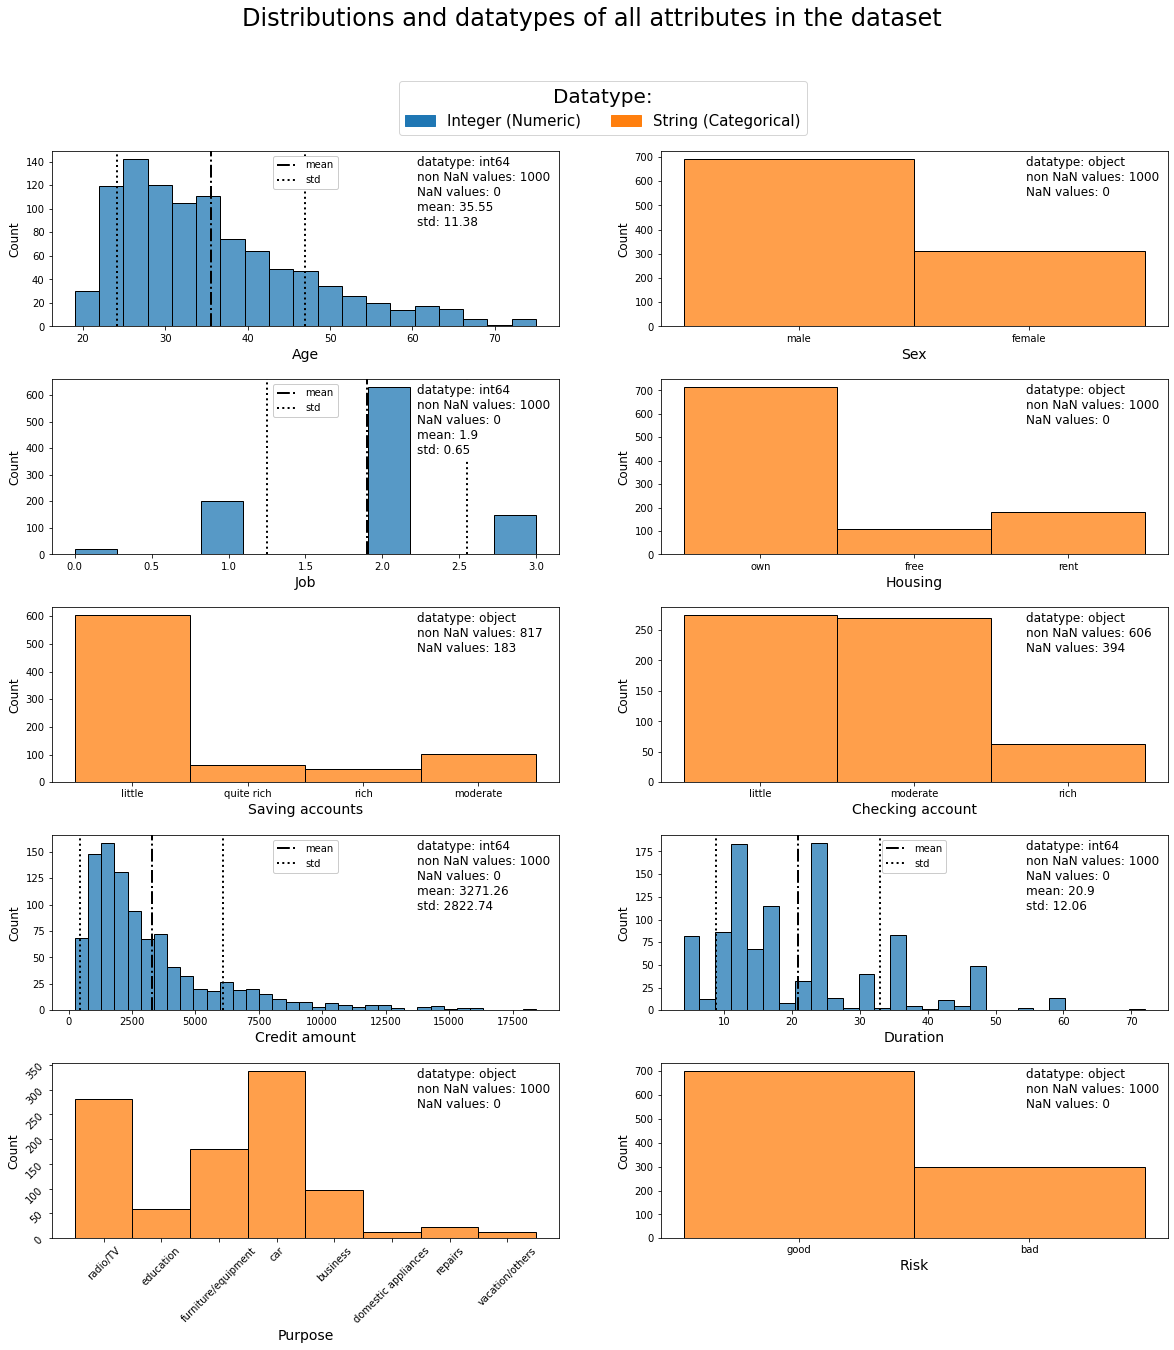

In [4]:
info_df = pd.DataFrame([df.dtypes, df.count(), df.shape[0] - df.count(), 
                        round(df.mean(numeric_only=True), 2), round(df.std(numeric_only=True), 2)])

fig, axes = plt.subplots(5,2, figsize=(20,20))

plt.subplots_adjust(hspace=0.3)

row = 0
col = 0
for attribute in list(df.columns):
    ax = axes[row][col]
    
    
    dtype = str(info_df[attribute].iloc[0])
    not_nan_count = str(info_df[attribute].iloc[1])
    nan_count = str(info_df[attribute].iloc[2])
    
    if dtype == 'int64':
        mean = str(info_df[attribute].iloc[3])
        std = str(info_df[attribute].iloc[4])
        additional_info = f'\nmean: {mean} \n' + f'std: {std}'
        color='tab:blue'
        ax.axvline(float(mean), 0, 1000, linestyle='-.', c='black', linewidth=2, label='mean')
        ax.axvline(float(mean) + float(std), 0, 1000, linestyle=':', c='black', linewidth=2, label='std')
        ax.axvline(float(mean) - float(std), 0, 1000, linestyle=':', c='black', linewidth=2)
        
        ax.legend(loc='upper center', framealpha=1)
    else:
        additional_info = ''
        color='tab:orange'

        
    sns.histplot(ax=ax, x=df[attribute], color=color, label=dtype)
    
    textstr = f'datatype: {dtype} \n' + f'non NaN values: {not_nan_count} \n' + f'NaN values: {nan_count}' + additional_info

    props = dict(boxstyle='round', facecolor='white', edgecolor='none', alpha=1)
    ax.text(0.72, 0.97, textstr, transform=ax.transAxes, fontsize=12, verticalalignment='top', bbox=props)
    
    if col == 0:
        col += 1
    else:
        row += 1
        col -= 1
        
    if attribute == 'Purpose':
        ax.tick_params(labelrotation=45)
        
    ax.yaxis.label.set_size(12)
    ax.xaxis.label.set_size(14)
    
        
numeric_patch = mpatches.Patch(color='tab:blue', label='Integer (Numeric)')
text_patch = mpatches.Patch(color='tab:orange', label='String (Categorical)')

fig.legend(handles=[numeric_patch, text_patch], title='Datatype:', loc=(0.34,0.9), fontsize=15, title_fontsize=20, ncol=2)
fig.suptitle('Distributions and datatypes of all attributes in the dataset', fontsize=24)


plt.show()

This first look has shown, that there are 4 attributes with the datatype integer and 6 attributes with the datatype string in this dataset. Given the variable description, we know that the attribute job is also categorial as it shows in the histogram aswell. Therefore, we can devide the attributes in the following groups: <br> <br>
**Numerical:** Age, Credit amount, Duration <br>
**Categorical:** Sex, Job, Housing, Savings account, Checking account, Purpose, Risk <br> <br>
This is important, because we will need to create dummy variables for the categorial variables, so that they can be used in classifying.

In [5]:
numerical_attributes = ['Age', 'Credit amount', 'Duration']
categorial_attributes = ['Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account', 'Purpose', 'Risk']

Let us see what kinds of categorial values there are:

In [6]:
for attr in categorial_attributes:
    print(f'{attr}: {list(df[attr].unique())}')

Sex: ['male', 'female']
Job: [2, 1, 3, 0]
Housing: ['own', 'free', 'rent']
Saving accounts: [nan, 'little', 'quite rich', 'rich', 'moderate']
Checking account: ['little', 'moderate', nan, 'rich']
Purpose: ['radio/TV', 'education', 'furniture/equipment', 'car', 'business', 'domestic appliances', 'repairs', 'vacation/others']
Risk: ['good', 'bad']


Let us also take a look at the numeric attributes:
**Why?**

In [7]:
df[numerical_attributes].describe().loc[['count','min', 'max']]

,Age,Credit amount,Duration
count,1000.0,1000.0,1000.0
min,19.0,250.0,4.0
max,75.0,18424.0,72.0


### Missing values
We will need to decide how to deal with missing values in the dataset.

There are 183 missing values in Saving account and 394 missing values in Checking account. All other values are plausible and do not require further attention. Let us take a look at the missing values:

In [8]:
df[df.isna().any(axis=1)].head(3)

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
2,49,male,1,own,little,NaN,2096,12,education,good
5,35,male,1,free,NaN,NaN,9055,36,education,good


In [9]:
print(f'There are {df.shape[0] - df.dropna().shape[0]} rows with missing values')

There are 478 rows with missing values


If we were to just remove all rows with missing values, we would loose *478* rows and therefore *47.8 %* of our data entrys. We must find an alternative solution. This leads us to data imputation. There are several options to impute data for categorial columns. We could use a classification method to try to predict the missing data or we could replace the missing values with the most frequently occuring category. These solutions, however, could add false information creating worse results. A safer solution is creating a new category for empty (NaN) values. This would prevent a loss of data in a simple way. We chose this method based on this source: https://towardsdatascience.com/7-ways-to-handle-missing-values-in-machine-learning-1a6326adf79e.

Let us replace the empty values with the category 'NaN':

In [10]:
df_dummies = df.fillna('NaN')

### Dummy variables

Next, we have to create dummy variables for the categorial variables, so that they can be used for classification. We make sure to set ``drop_first=True`` to get k-1 dummies out of k categorical levels. This reduces the number of dummies, while retaining all information.

In [11]:
df_dummies = pd.get_dummies(df_dummies, drop_first=True)

In [21]:
print(f'Our new dataset with dummies now has the shape ({df_dummies.shape[0]}, {df_dummies.shape[1]}). 12 new columns have been created from the qualitative attributes.')
df_dummies.head(3)

Our new dataset with dummies now has the shape (1000, 22). 12 new columns have been created from the qualitative attributes.


,Age,Job,Credit amount,Duration,Sex_male,Housing_own,Housing_rent,Saving accounts_little,Saving accounts_moderate,Saving accounts_quite rich,...,Checking account_moderate,Checking account_rich,Purpose_car,Purpose_domestic appliances,Purpose_education,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_repairs,Purpose_vacation/others,Risk_good
0,67,2,1169,6,1,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
1,22,2,5951,48,0,1,0,1,0,0,...,1,0,0,0,0,0,1,0,0,0
2,49,1,2096,12,1,1,0,1,0,0,...,0,0,0,0,1,0,0,0,0,1


### Correlation analysis

For our machine learning techniques to work, we will need to find structure and dependencies in the data. To get a first look at the potential of our dataset, we will take a look at the correlation between all attributes.

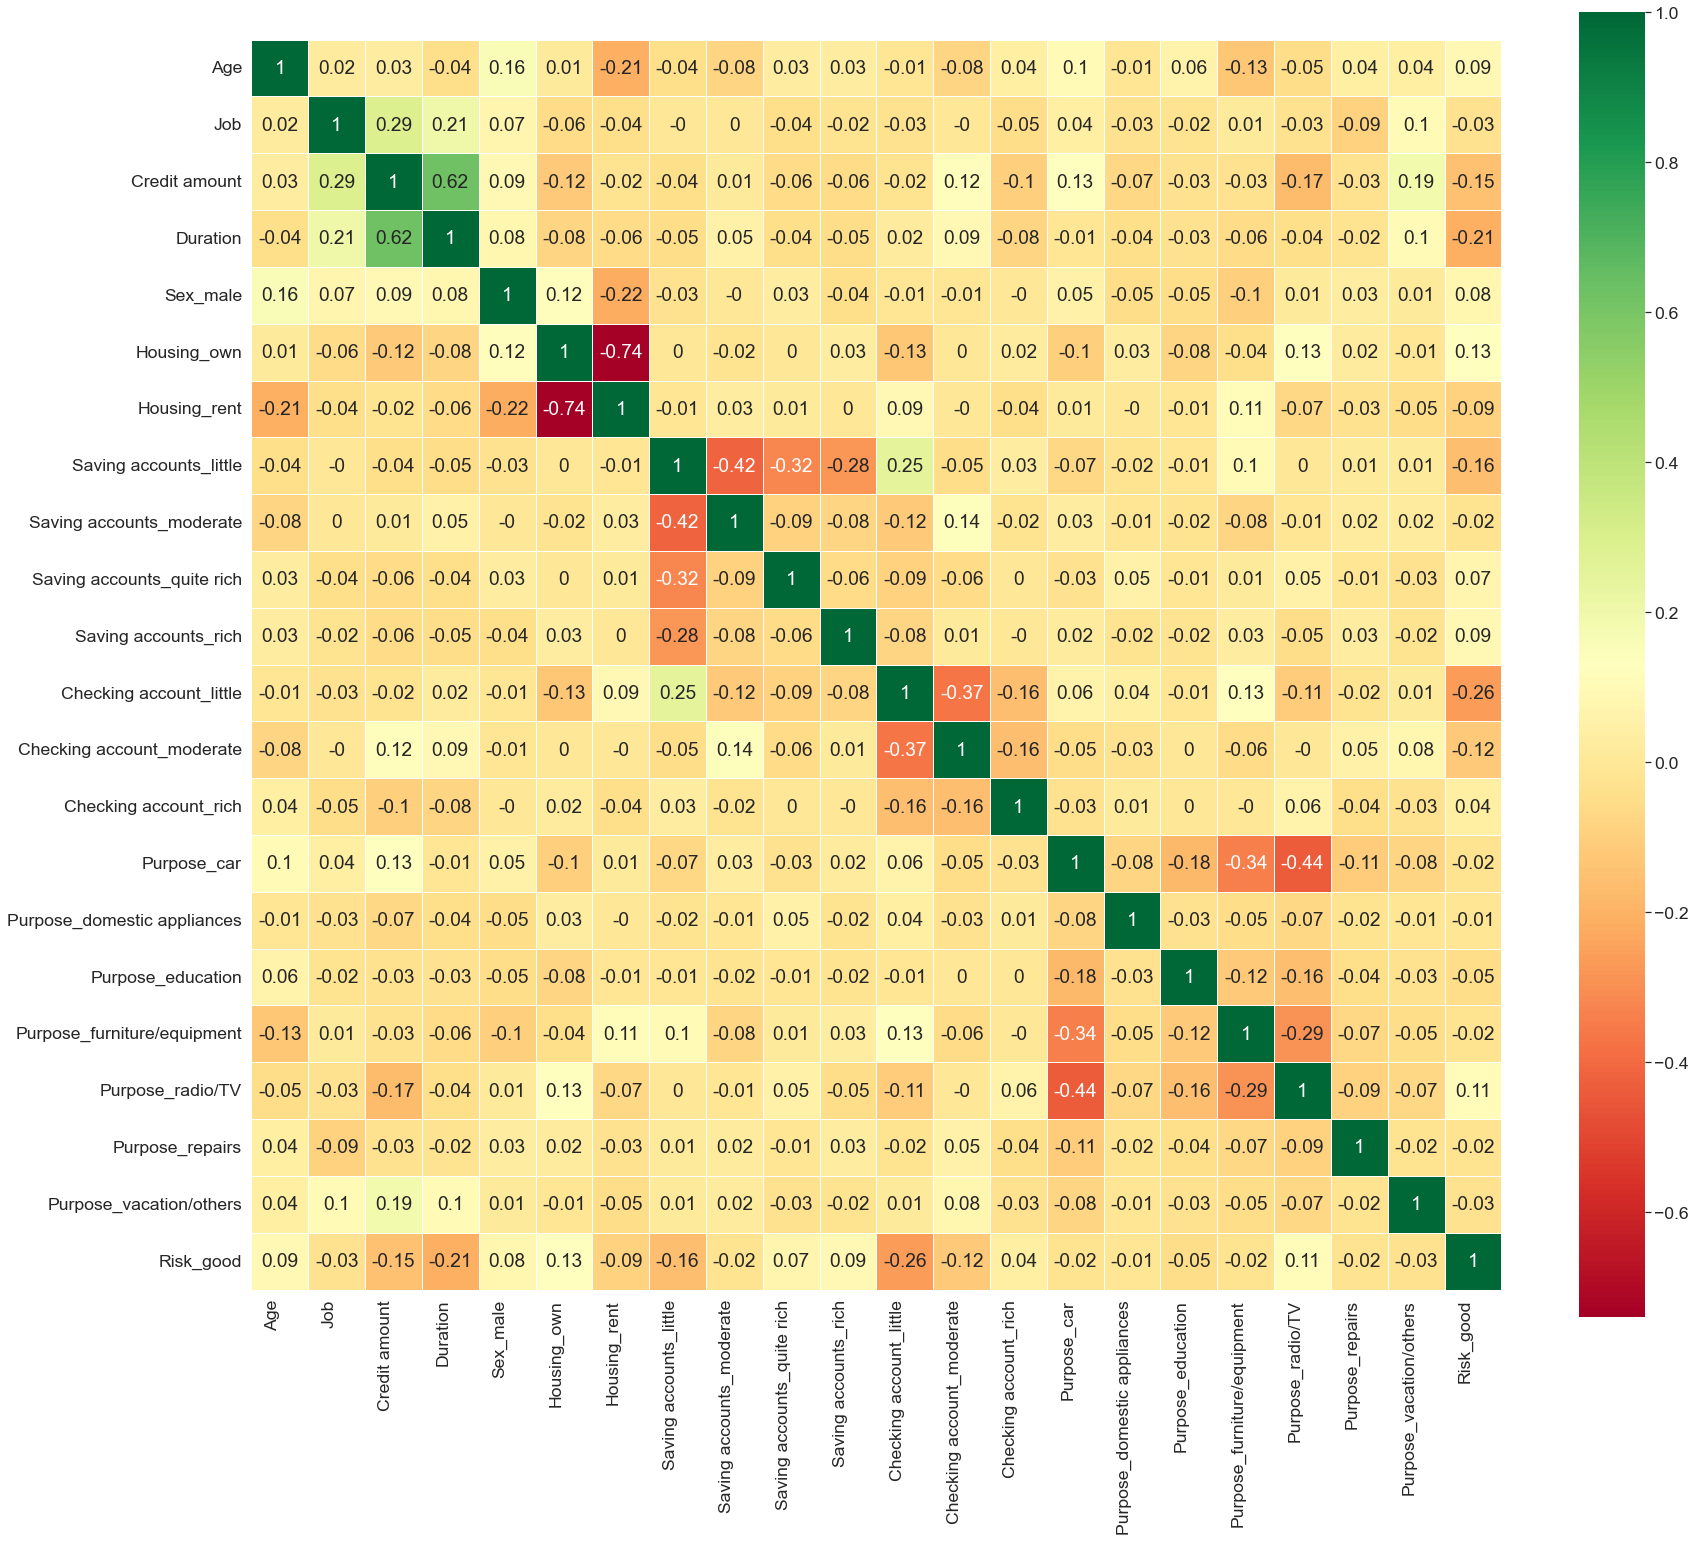

In [12]:
sns.set(font_scale=1.6)
corr = df_dummies.corr().round(2)
fig, ax = plt.subplots(figsize=(28,24))
h = sns.heatmap(corr, cmap=plt.cm.RdYlGn, annot=True, linewidths=1, square=True, ax=ax)
ax.set_ylim(len(corr),0)
h.set_xticklabels(h.get_xticklabels(), rotation=90, ha='right')
h.set_yticklabels(h.get_yticklabels(), rotation=0, ha='right')
sns.set(font_scale=1)

In [13]:
print('The correlations with Risk_good are:')
corr['Risk_good'].sort_values(ascending=False)[1:]

The correlations with Risk_good are:


Housing_own                    0.13
Purpose_radio/TV               0.11
Saving accounts_rich           0.09
Age                            0.09
Sex_male                       0.08
Saving accounts_quite rich     0.07
Checking account_rich          0.04
Purpose_domestic appliances   -0.01
Saving accounts_moderate      -0.02
Purpose_car                   -0.02
Purpose_furniture/equipment   -0.02
Purpose_repairs               -0.02
Job                           -0.03
Purpose_vacation/others       -0.03
Purpose_education             -0.05
Housing_rent                  -0.09
Checking account_moderate     -0.12
Credit amount                 -0.15
Saving accounts_little        -0.16
Duration                      -0.21
Checking account_little       -0.26
Name: Risk_good, dtype: float64

Clearly, there are many attributes with very low correlation to the target *Risk*. This suggests, that a strict subset selection may be useful.

Now that we know the correlations, it may be interesting to look at a few more visualizations. Since the bank account values are more correlated with the risk than many others, let us take a more detailed look at their categories. We will first group each attribute by the risk and then calculate how often there is a *good* risk in each category. 

In [14]:
checking_analysis = df.groupby(['Checking account', 'Risk'], dropna=False).count()['Age']
checking_index = checking_analysis.index.get_level_values(0).unique()
checking_percentages = [checking_analysis.iloc[i+1] / (checking_analysis.iloc[i] + checking_analysis.iloc[i+1]) for i in range(0,len(checking_analysis),2)]
checking_series = pd.Series(checking_percentages, index=checking_index)

savings_analysis = df.groupby(['Saving accounts', 'Risk'], dropna=False).count()['Age']
savings_index = savings_analysis.index.get_level_values(0).unique()
savings_percentages = [savings_analysis.iloc[i+1] / (savings_analysis.iloc[i] + savings_analysis.iloc[i+1]) for i in range(0,len(savings_analysis),2)]
savings_series = pd.Series(savings_percentages, index=savings_index)

percentages_df = pd.DataFrame(columns=['Checking account', 'Saving accounts'])
percentages_df['Checking account'] = checking_series * 100
percentages_df['Saving accounts'] = savings_series * 100

percentages_df

,Checking account,Saving accounts
Checking account,,
little,50.729927,64.013267
moderate,60.966543,66.990291
rich,77.777778,87.500000
NaN,88.324873,82.513661


The above dataframe now contains information about what percentage of the entrys have *good* risk dependent on the categories [little, moderate, rich and NaN] for both the checking account and saving accounts. Let us plot this and some other interesting attributes.

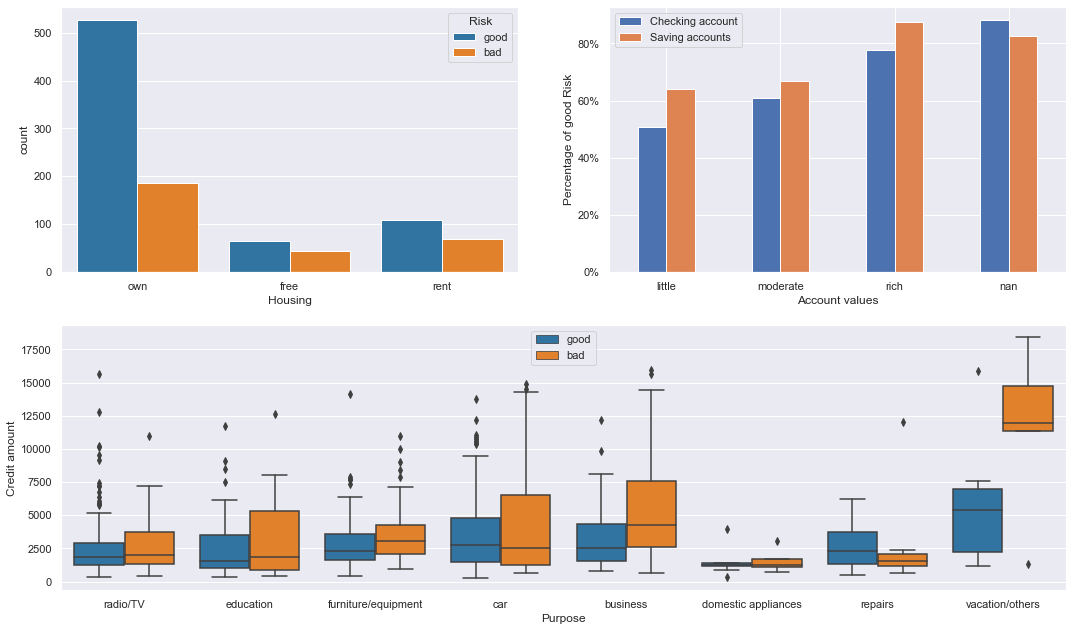

In [15]:
plt.figure(figsize = (18,12))

plt.subplot(221)
sns.countplot(x='Housing', hue='Risk', data=df, palette="tab10")

g2 = plt.subplot(222)
percentages_df.plot(ax=g2, kind='bar')
g2.set_ylabel('Percentage of good Risk')
g2.set_xlabel('Account values')
g2.yaxis.set_major_formatter(mtick.PercentFormatter())
g2.tick_params(axis='x', labelrotation=0)

g3 = plt.subplot(212)
sns.boxplot(x="Purpose", y="Credit amount", data=df, hue="Risk", palette="tab10")
g3.legend(loc='upper center')

plt.subplots_adjust(hspace = 0.2, wspace=0.2, top = 0.8)

plt.show()

Analyzing the outputs, it can be seen how both housing and account values are correlated to the risk. For example, a higher account value in both the checking and savings account, lead to a lower risk for the bank (a higher percentage of good risk).
Taking a look at the credit amount, you can see the negative correlation with the good risk clearly, as higher amounts are related to a *bad* risk more often. Furthermore, looking at the account values, it can be observed how missing values are correlated to a lower (*good*) risk aswell. This could be an indication that when there is no information about the account value, it is usually a high value and therefore more strongly correlated with a lower risk. This indicates that using the missing values for prediction may be useful.

## 3. Preprocessing <a name='preprocessing'></a>